In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os, sys
import pyedflib
from tqdm import tqdm
from scipy import io
from math import sqrt
from pyedflib import highlevel

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [4]:
MMI_SUBJECT = 100
MMI_TRIAL = 14
MMI_CHANNEL = 64
MMI_SEQ_LEN = 20 # 20, 80, 160, 960, 1600
MMI_COR_LEN = 8 # 8, 10, 10, 10, 6
seq_len = int(156000/20) # 20, 80, 160
#cor_len = int(seq_len/MMI_COR_LEN)
cor_len = 432 #no rest included

print(seq_len, cor_len)

7800 432


## Save Data

In [5]:
#160Hz
#106번 이상
file_path='./eegmmidb_edf/S'
save_path='./eegmmidb_feature/S'

MMI_single_channel = np.zeros((64, seq_len))
MMI_channel_wise = np.zeros((cor_len, 64, 64))
                        
for i in tqdm(range(105,106)):
        for j in range(MMI_TRIAL):
            path = file_path+str(i+1).zfill(3)+'/s'+str(i+1).zfill(3)+'R'+str(j+1).zfill(2)+'.edf'
            signals, signal_header, header = highlevel.read_edf(path)
            print(signals.shape)
            
            if(j==0 or j==1):
                k = int(6000/20)
                for m in range(k):
                    temp = signals[:,m*20:(m+1)*20]
                    temp = np.nanmean(temp, axis=1)
                    MMI_single_channel[:,j*k+m] = temp
            else:
                k = int(12000/20)
                for m in range(k):
                    temp = signals[:,m*20:(m+1)*20]
                    temp = np.nanmean(temp ,axis=1)
                    MMI_single_channel[:,k*(j-1)+m] = temp
                    
        for m in range(cor_len):
            MMI_channel_wise[m,:,:] = np.corrcoef(MMI_single_channel[:,m*MMI_COR_LEN:(m+1)*MMI_COR_LEN])
        path = save_path+str(i+1).zfill(3) 
        #np.save(path+'/user_id_20_8', MMI_channel_wise) #저장할때만

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


OSError: File ./eegmmidb_edf/S106/s106R01.edf was found but cant be accessed. Make sure it contains no special characters or change your locale to use UTF8.

In [12]:
# seq 1분
file_path='./eegmmidb_edf/S'
save_path='./eegmmidb_feature/S'

MMI_single_channel = np.zeros((64, seq_len))
MMI_channel_wise = np.zeros((cor_len, 64, 64))
                        
for i in tqdm(range(MMI_SUBJECT)):
        for j in range(MMI_TRIAL):
            path = file_path+str(i+1).zfill(3)+'/s'+str(i+1).zfill(3)+'R'+str(j+1).zfill(2)+'.edf'
            signals, signal_header, header = highlevel.read_edf(path)
            
                
            if(j==0 or j==1):
                k = int(9600/MMI_SEQ_LEN)
                for m in range(k):
                    temp = signals[:,m*MMI_SEQ_LEN:(m+1)*MMI_SEQ_LEN]
                    temp = np.nanmean(temp, axis=1)
                    MMI_single_channel[:,j*k+m] = temp
            else:
                k = int(9600/MMI_SEQ_LEN)
                for m in range(k):
                    temp = signals[:,m*MMI_SEQ_LEN:(m+1)*MMI_SEQ_LEN]
                    temp = np.nanmean(temp ,axis=1)
                    MMI_single_channel[:,k*j+m] = temp
                    
        for m in range(cor_len):
            MMI_channel_wise[m,:,:] = np.corrcoef(MMI_single_channel[:,m*MMI_COR_LEN:(m+1)*MMI_COR_LEN])
        path = save_path+str(i+1).zfill(3) 
        #np.save(path+'/user_id_temp', MMI_channel_wise) #저장할때만

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:41<00:00,  2.11s/it]


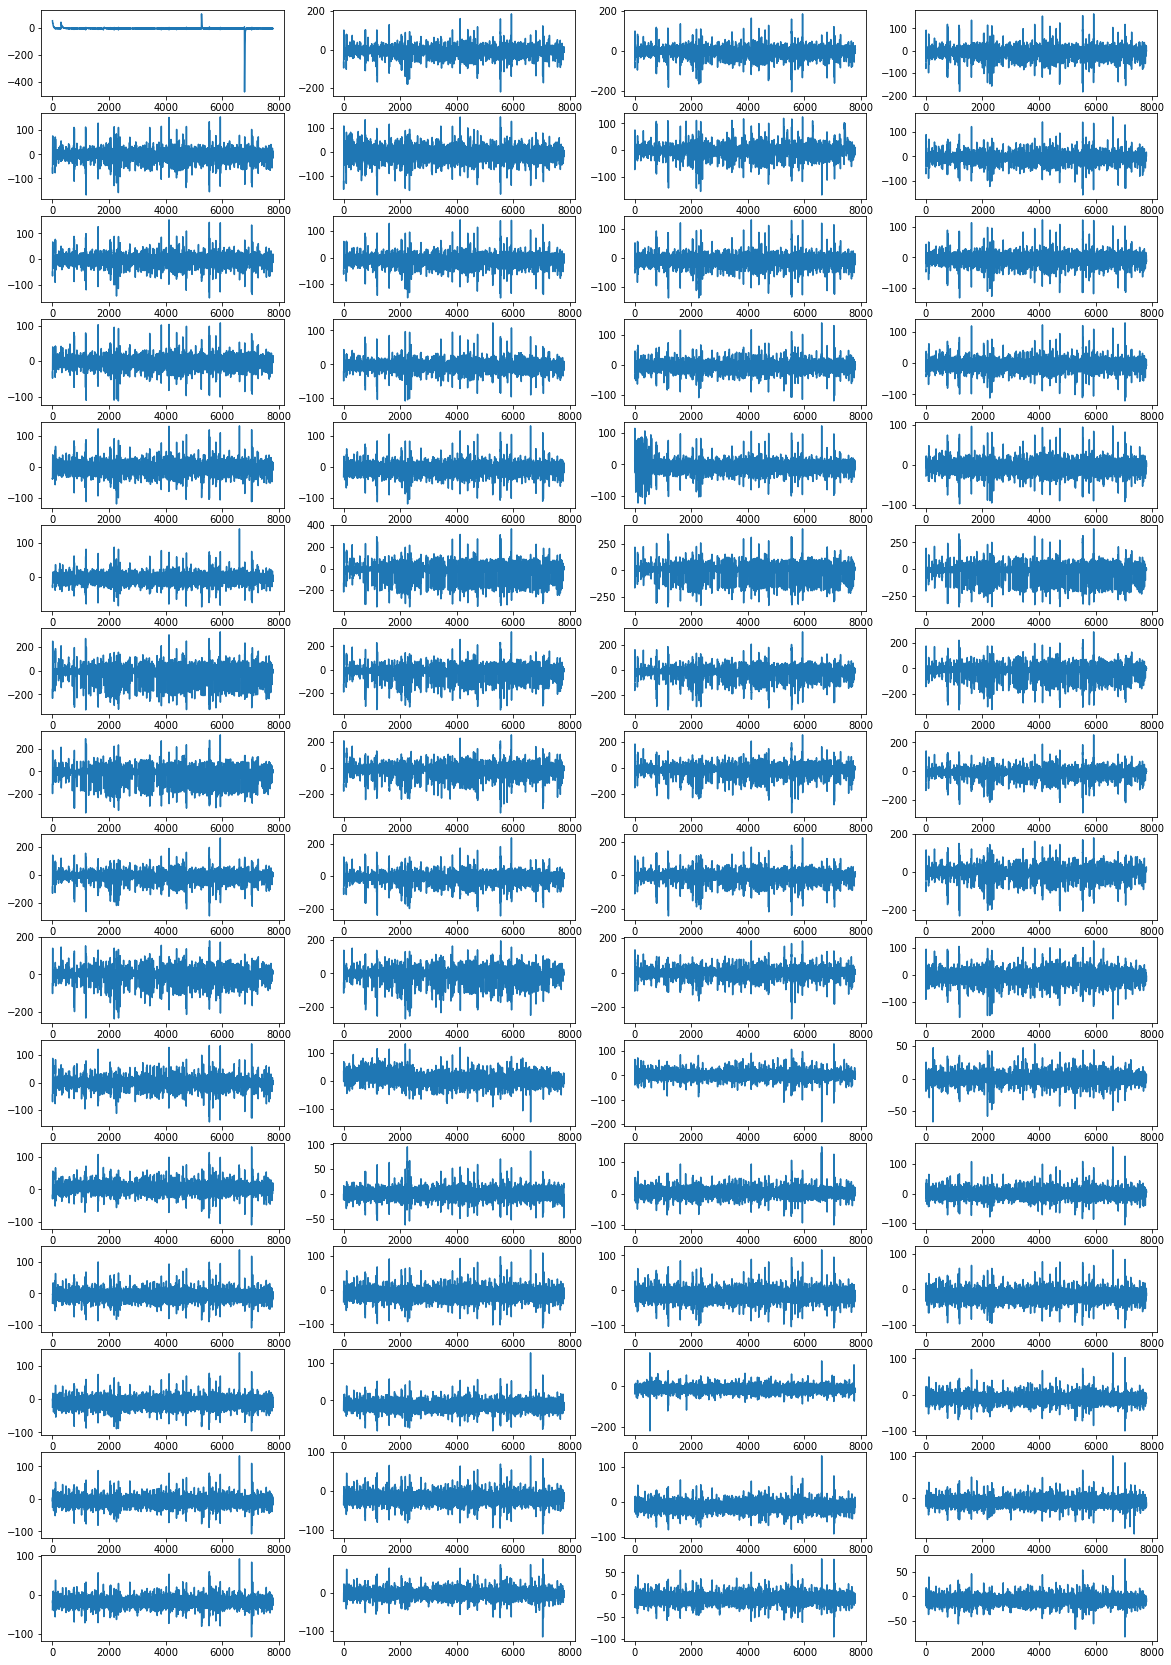

In [12]:
plt.figure(figsize=(20,30))
for i in range(16):
    for j in range(4):
        plt.subplot(16, 4, 4*i+j+1)
        plt.plot(MMI_single_channel[4*i+j])

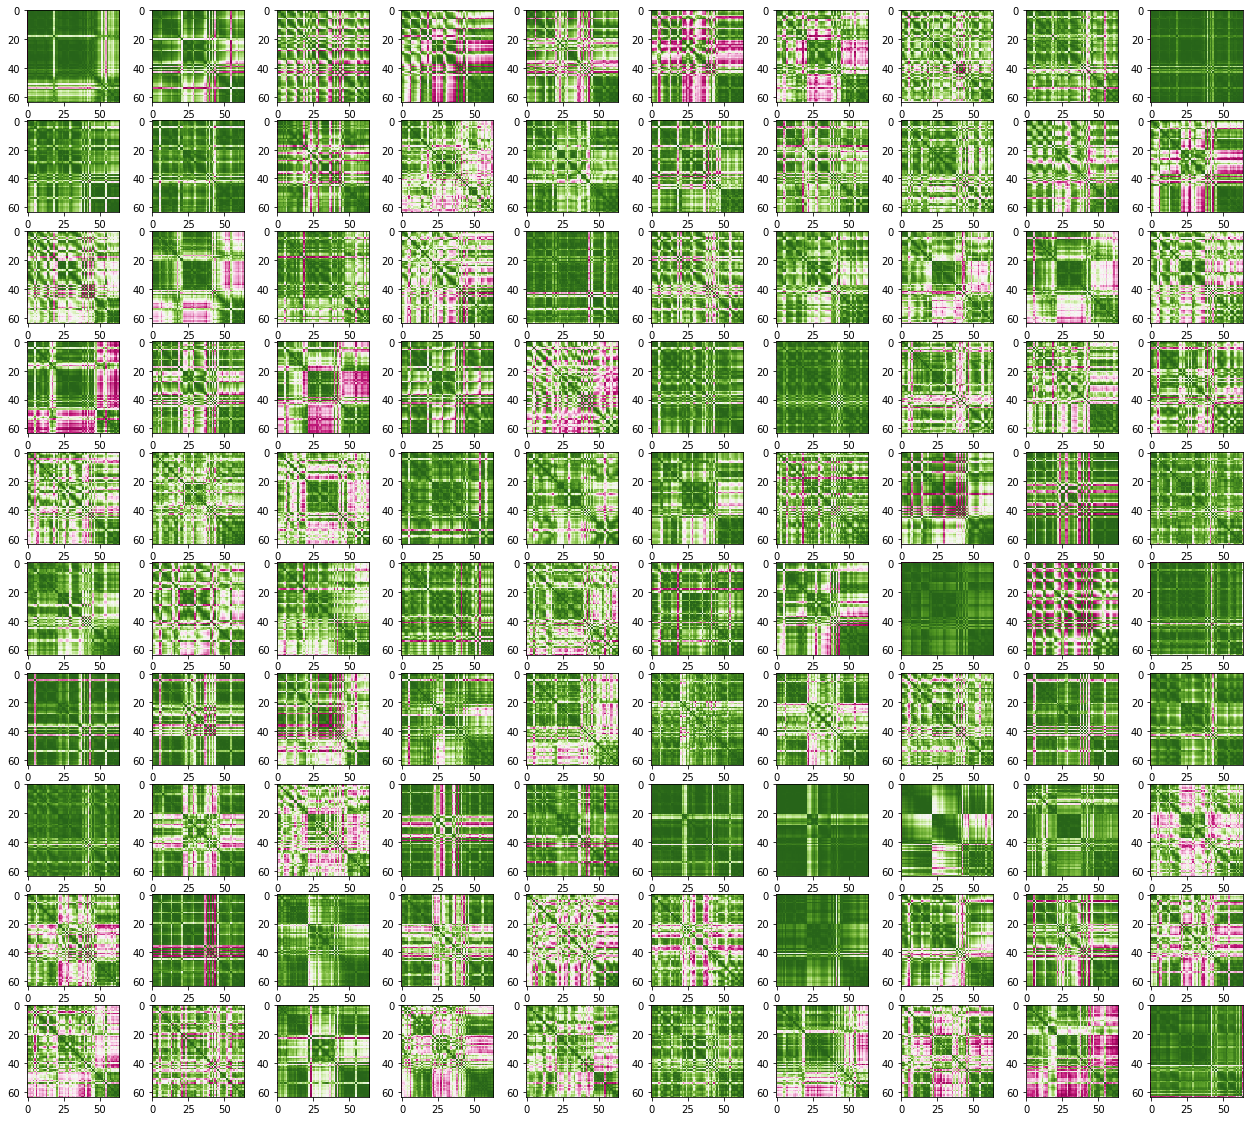

In [14]:
plt.figure(figsize=(22,20))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(MMI_channel_wise[10*i+j,:,:], cmap='PiYG')

## Load data

In [3]:
load_path = './eegmmidb_feature/S'

MMI_channel_wise = []
temp = np.zeros((cor_len,64,64))

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105):
        continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')    
        
    MMI_channel_wise.append(temp)
    #MMI_channel_wise.append(temp)
    
MMI_channel_wise = np.array(MMI_channel_wise)
MMI_channel_wise = MMI_channel_wise.reshape(-1, 64, 64, 1)
print(MMI_channel_wise.shape)

label = np.zeros((len(MMI_channel_wise), MMI_SUBJECT))

for i in range(len(label)):
    k = int(i/(len(MMI_channel_wise)/MMI_SUBJECT))
    label[i][k] = 1

print(MMI_channel_wise.shape)
print(label.shape)

idx = [i for i in range(len(MMI_channel_wise))]
np.random.shuffle(idx)
MMI_channel_wise = MMI_channel_wise[idx]
label = label[idx]

cutoff = int(len(MMI_channel_wise)*0.9)

train_data = MMI_channel_wise[:cutoff,:,:,:]
train_label = label[:cutoff,:]
test_data = MMI_channel_wise[cutoff:,:,:,:]
test_label = label[cutoff:,:]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.32it/s]


(97500, 64, 64, 1)
(97500, 64, 64, 1)
(97500, 100)
(87750, 64, 64, 1) (87750, 100)
(9750, 64, 64, 1) (9750, 100)


In [3]:
load_path = './eegmmidb_feature/S'

#train_data = np.zeros((0,64,64))
#test_data = np.zeros((0,64,64))
train_data = []
test_data = []

"""for i in tqdm(range(MMI_SUBJECT)):
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    cut_start = int(len(temp) * 0.2)
    cut_end = int(len(temp) * 0.4)
    train_data = np.append(train_data, temp[:cut_start], axis=0)
    test_data = np.append(test_data, temp[cut_start:cut_end], axis=0)
    train_data = np.append(train_data, temp[cut_end:],axis=0)"""

for i in tqdm(range(MMI_SUBJECT)):
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    cut_off = int(len(temp) * 0.8)
    train_data.append(temp[:cut_off])
    test_data.append(temp[cut_off:])

train_data = np.array(train_data)
test_data = np.array(test_data)
print(train_data.shape, test_data.shape)

train_data = train_data.reshape(-1, 64, 64, 1)
test_data = test_data.reshape(-1, 64, 64, 1)

train_label = np.zeros((len(train_data), MMI_SUBJECT))
test_label = np.zeros((len(test_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_data.shape, test_data.shape)
print(train_label.shape, test_label.shape)

idx = [i for i in range(len(train_data))]
np.random.shuffle(idx)
train_data = train_data[idx]
train_label = train_label[idx]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.04it/s]


(100, 780, 64, 64) (100, 195, 64, 64)
(78000, 64, 64, 1) (19500, 64, 64, 1)
(78000, 100) (19500, 100)


In [4]:
import keras
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [5]:
inputs = Input(shape=(64,64,1))
x = Conv2D(64, (1,64), activation='relu')(inputs)
x = Reshape((64,64,1))(x)
x = Conv2D(6, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(6, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(6, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid')(x)

sgd = keras.optimizers.SGD()
adam = keras.optimizers.Adam(learning_rate=0.0002)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback_list = [ModelCheckpoint(filepath='MMI_44.h5',
                                monitor='val_accuracy', save_best_only=True)]
              
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 1, 64)         4160      
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 8)         32        
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)        

In [6]:
history = model.fit(train_data, train_label, epochs=100, batch_size = 200,
                   validation_data=(test_data, test_label), callbacks=callback_list, verbose=2)

Epoch 1/100
390/390 - 14s - loss: 4.4956 - accuracy: 0.0237 - val_loss: 5.0946 - val_accuracy: 0.0154
Epoch 2/100
390/390 - 14s - loss: 3.6871 - accuracy: 0.1756 - val_loss: 2.5230 - val_accuracy: 0.4073
Epoch 3/100
390/390 - 13s - loss: 1.6028 - accuracy: 0.5958 - val_loss: 1.0805 - val_accuracy: 0.7244
Epoch 4/100
390/390 - 12s - loss: 0.8070 - accuracy: 0.7849 - val_loss: 1.3947 - val_accuracy: 0.6799
Epoch 5/100
390/390 - 14s - loss: 0.5103 - accuracy: 0.8583 - val_loss: 0.4858 - val_accuracy: 0.8731
Epoch 6/100
390/390 - 13s - loss: 0.3637 - accuracy: 0.8972 - val_loss: 0.4705 - val_accuracy: 0.8783
Epoch 7/100
390/390 - 13s - loss: 0.2828 - accuracy: 0.9187 - val_loss: 0.3828 - val_accuracy: 0.8990
Epoch 8/100
390/390 - 14s - loss: 0.2233 - accuracy: 0.9351 - val_loss: 0.3737 - val_accuracy: 0.9049
Epoch 9/100
390/390 - 12s - loss: 0.1837 - accuracy: 0.9451 - val_loss: 0.4839 - val_accuracy: 0.8793
Epoch 10/100
390/390 - 13s - loss: 0.1610 - accuracy: 0.9509 - val_loss: 0.3589 - 

Epoch 79/100
390/390 - 12s - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.2236 - val_accuracy: 0.9511
Epoch 80/100
390/390 - 12s - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.2105 - val_accuracy: 0.9561
Epoch 81/100
390/390 - 12s - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.2146 - val_accuracy: 0.9549
Epoch 82/100
390/390 - 12s - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.2164 - val_accuracy: 0.9535
Epoch 83/100
390/390 - 12s - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.2334 - val_accuracy: 0.9505
Epoch 84/100
390/390 - 12s - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.2276 - val_accuracy: 0.9503
Epoch 85/100
390/390 - 12s - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.2191 - val_accuracy: 0.9535
Epoch 86/100
390/390 - 12s - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.2212 - val_accuracy: 0.9550
Epoch 87/100
390/390 - 12s - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.2086 - val_accuracy: 0.9566
Epoch 88/100
390/390 - 12s - loss: 0.0056 - accuracy: 0.9984 - val_loss: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MIDDLE LAYER OUTPUT

In [7]:
#if you want load model run this code block
import keras
import numpy as np
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = keras.models.load_model('MMI_44.h5')

In [22]:
load_path = './eegmmidb_feature/S'
path = load_path+str(5).zfill(3)+'/'
temp = np.load(path+'user_id_20_8.npy')
sample_input = temp.reshape(-1,64,64,1)
print(sample_input.shape)

layer_outputs = [layer.output for layer in model.layers[:]]
multioutput_model = Model(inputs=model.input, outputs=layer_outputs)

activations = multioutput_model.predict(sample_input)

print('Number of layers:', len(activations))
print('Datatype:',type((activations[0])))
print('1st layer output shape:', activations[2].shape)
print('4nd layer output shape:', activations[3].shape)
print('8th layer output shape:', activations[6].shape)

(975, 64, 64, 1)
Number of layers: 15
Datatype: <class 'numpy.ndarray'>
1st layer output shape: (975, 64, 64, 1)
4nd layer output shape: (975, 62, 62, 8)
8th layer output shape: (975, 60, 60, 8)


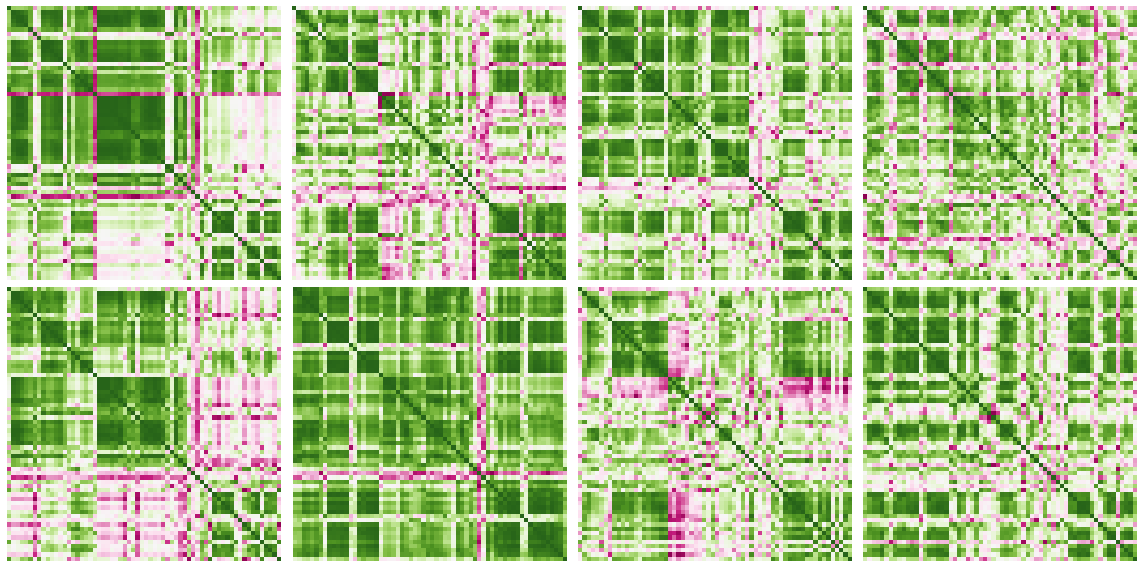

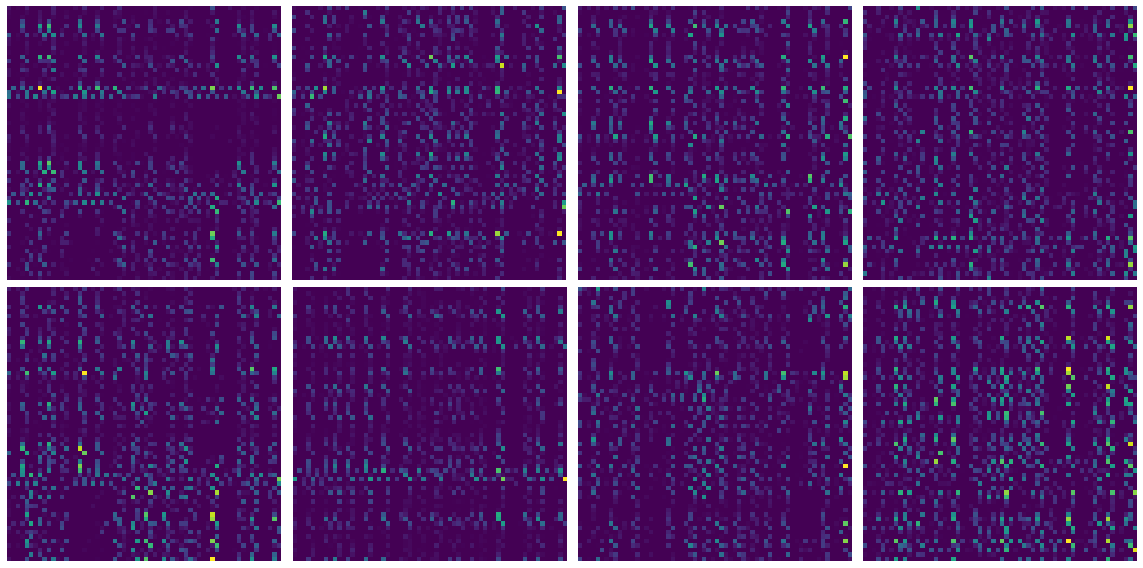

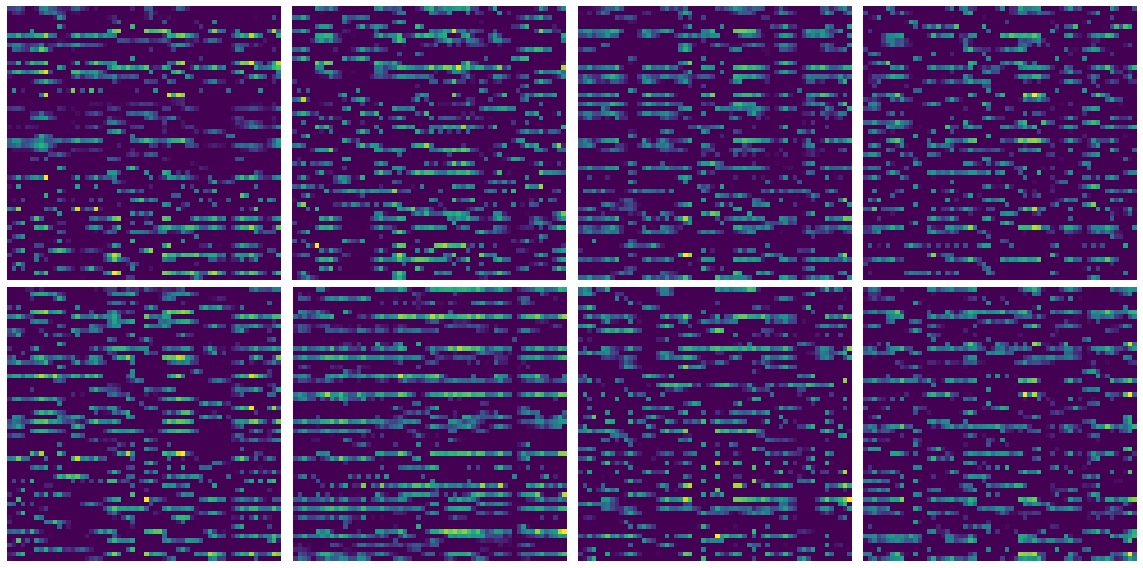

In [23]:
plt.figure(figsize=(16,8))
plt.title('activation')
for i in range(2):
    for j in range(4):
        plt.subplot(2,4,i*4+j+1)
        plt.axis('off')
        plt.imshow(activations[0][i*4+j,:,:,0], cmap='PiYG')
plt.tight_layout()
plt.savefig('pic/5_out_1.png')
plt.show()

plt.figure(figsize=(16,8))
plt.title('activation')
for i in range(2):
    for j in range(4):
        plt.subplot(2,4,i*4+j+1)
        plt.axis('off')
        plt.imshow(activations[3][i*4+j,:,:,0], cmap='viridis')
plt.tight_layout()
plt.savefig('pic/5_out_2.png')
plt.show()

plt.figure(figsize=(16,8))
plt.title('activation')
for i in range(2):
    for j in range(4):
        plt.subplot(2,4,i*4+j+1)
        plt.axis('off')
        plt.imshow(activations[6][i*4+j,:,:,0], cmap='viridis')
plt.tight_layout()
plt.savefig('pic/5_out_3.png')
plt.show()


In [7]:
inputs = Input(shape=(64,64,1))
x = Flatten()(inputs)
x = Dense(2048, activation='relu')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid')(x)

adam = Adam(learning_rate=0.0002)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback_list = [ModelCheckpoint(filepath='MMI_44.h5',
                                monitor='val_accuracy', save_best_only=True)]
              
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_4 (Dense)              (None, 100)               204900    
Total params: 8,595,556
Trainable params: 8,595,556
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_data, train_label, epochs=50, batch_size = 100,
                   validation_data=(test_data, test_label), callbacks=callback_list, verbose=2)

Train on 87750 samples, validate on 9750 samples
Epoch 1/50
 - 8s - loss: 3.1463 - accuracy: 0.2997 - val_loss: 2.1119 - val_accuracy: 0.5105
Epoch 2/50
 - 8s - loss: 1.7610 - accuracy: 0.5927 - val_loss: 1.5547 - val_accuracy: 0.6292
Epoch 3/50
 - 8s - loss: 1.3889 - accuracy: 0.6734 - val_loss: 1.2973 - val_accuracy: 0.6769
Epoch 4/50
 - 8s - loss: 1.1745 - accuracy: 0.7199 - val_loss: 1.1222 - val_accuracy: 0.7280
Epoch 5/50
 - 8s - loss: 1.0250 - accuracy: 0.7553 - val_loss: 1.0304 - val_accuracy: 0.7520
Epoch 6/50
 - 8s - loss: 0.9241 - accuracy: 0.7761 - val_loss: 0.9644 - val_accuracy: 0.7629
Epoch 7/50
 - 8s - loss: 0.8446 - accuracy: 0.7936 - val_loss: 0.9230 - val_accuracy: 0.7671
Epoch 8/50
 - 8s - loss: 0.7667 - accuracy: 0.8120 - val_loss: 0.9200 - val_accuracy: 0.7713
Epoch 9/50
 - 8s - loss: 0.7203 - accuracy: 0.8229 - val_loss: 0.8084 - val_accuracy: 0.8031
Epoch 10/50
 - 8s - loss: 0.6654 - accuracy: 0.8351 - val_loss: 0.7476 - val_accuracy: 0.8132
Epoch 11/50
 - 8s - 

KeyboardInterrupt: 